# LoCoMock (LogP-corrected Membrane Docking)

This program is a modified extension of Jupyter_Dock[https://github.com/AngelRuizMoreno/Jupyter_Dock].

Place this notebook on the "Jupyter_Dock" directory.

In [1]:
import sys, os
import shutil
import glob
import math
import numpy as np

from pymol import cmd
import py3Dmol
from vina import Vina
from openbabel import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdCoordGen
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdMolDescriptors

sys.path.insert(1, 'utilities/')
from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

## Plot Settings

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.dpi'] = 300
# matplotlib.rcParams['font.family'] = "Helvetica"

matplotlib.rcParams.update({'figure.figsize': [83/25.4, 83/25.4]})

## Project Settings

In [3]:
str_id = "targetID"
n_poses = 1000
membrane_pos = 14.7
buffer = 4.7

## Make working directory

In [4]:
try:
    print(WDIR)
except:
    WDIR = os.getcwd()

In [5]:
os.makedirs(f"{WDIR}/LoCoMock_{str_id}/", exist_ok=True)
os.chdir(f"{WDIR}/LoCoMock/LoCoMock_{str_id}/")

# Prepare input

Please predict the orientation and membrane position for your protein at PPM server [https://opm.phar.umich.edu/ppm_server3].


Place PDB files for protein (protein.pdb) and ligand (ligand.pdb) in the ./LoCoMock/{str_id} .


The protein.pdb should contain the thickness of the membrane in the first line otherwise the default value 14.7 is used.


Ex. "REMARK      1/2 of bilayer thickness:   17.4"

In [6]:
protein_pdb = ""
with open(f"./protein.pdb", "r") as f:
    resn = None
    chain_id = None
    for line in f:
        if "bilayer" in line:
            membrane_pos = float(line.split()[5])
        if "ATOM" in line and line[21]:
            protein_pdb += line
print(f"The membrane position is {membrane_pos}")

The membrane position is 14.7


In [7]:
with open(f"./protein_clean.pdb", "w") as f:
    f.write(protein_pdb)

## Prepare Protein

In [8]:
!../../bin/lepro_linux_x86 {'protein_clean.pdb'}
os.rename('pro.pdb','protein_H.pdb')

## Prepare Ligand

In [9]:
pdb_mol = [m for m in pybel.readfile("pdb", f"./ligand.pdb")][0]
out=pybel.Outputfile(filename='./ligand.pdbqt', format='pdbqt',overwrite=True, opt={"h": 7.0})
out.write(pdb_mol)
out.close()
    
pdbqt_mol = [m for m in pybel.readfile("pdbqt", f"./ligand.pdbqt")][0]
out=pybel.Outputfile(filename='./ligand_clean.pdb', format='pdb',overwrite=True)
out.write(pdbqt_mol)
out.close()

out=pybel.Outputfile(filename='./ligand.mol2',format='mol2',overwrite=True)
out.write(pdbqt_mol)
out.close()

## Show ligand structure

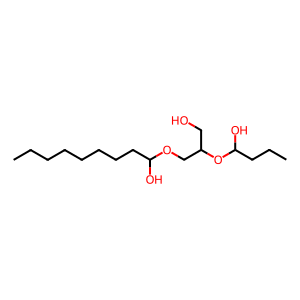

In [10]:
mol_noH = Chem.MolFromPDBFile("./ligand.pdbqt")
mol = Chem.RemoveHs(mol_noH)
rdCoordGen.AddCoords(mol)
Draw.MolToImage(mol)

## Show ligand logP

The logP of the target ligand is 2.5680000000000005


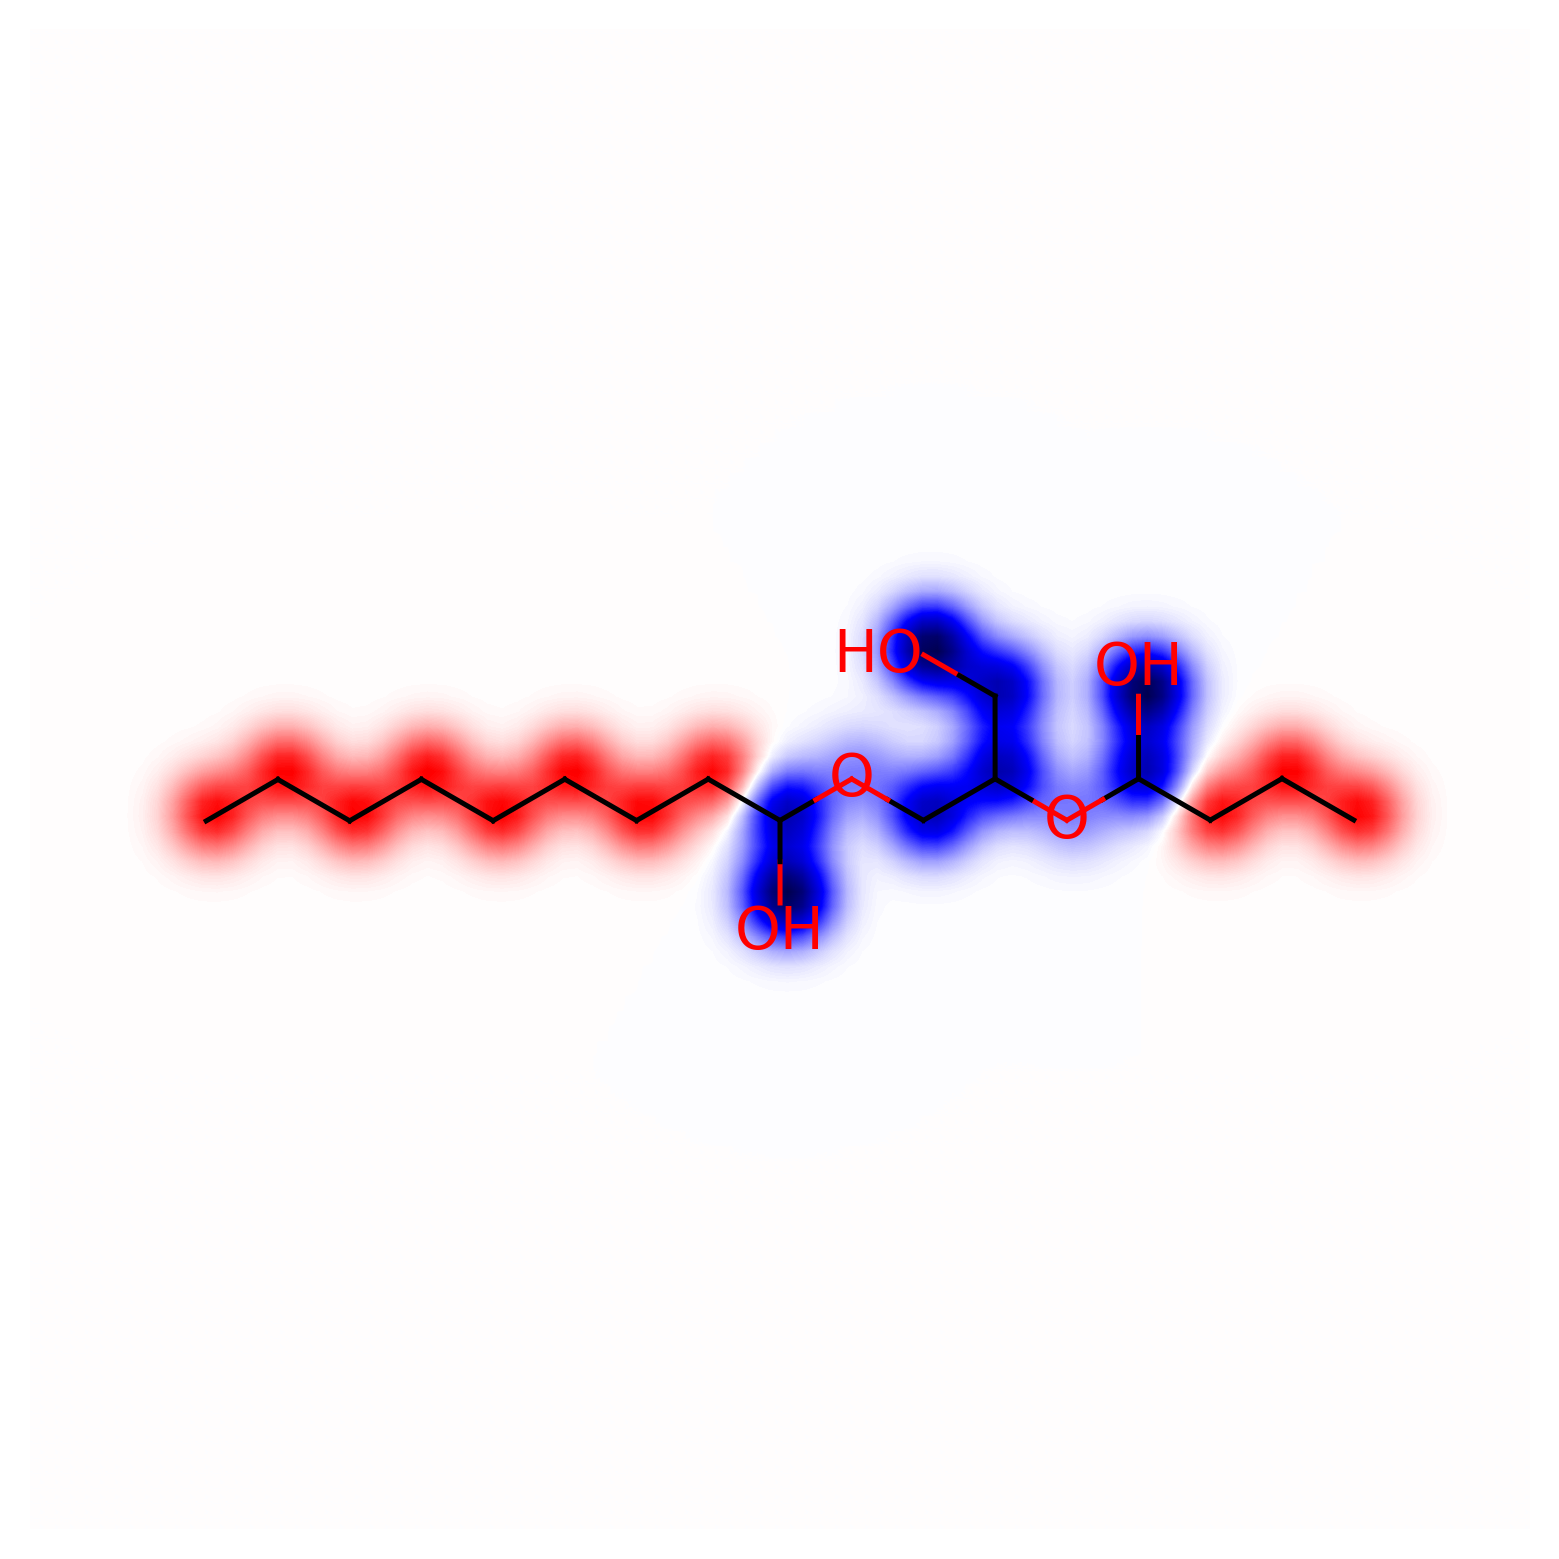

In [11]:
print(f"The logP of the target ligand is {Descriptors.MolLogP(mol)}")
contribs = rdMolDescriptors._CalcCrippenContribs(mol)
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol,[x for x,y in contribs], colorMap='seismic', contourLines=0, sigma=0.02, size=(200,200))
fig.savefig('ligand_logP.png',bbox_inches='tight', dpi=300) 
plt.show()

## Input System Visualization

In [12]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('protein_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open(f"./ligand.pdb",'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Docking with AutoDock Vina

In [13]:
!../../bin/prepare_receptor -v -r protein_H.pdb -o protein_H.pdbqt

set verbose to  True
set receptor_filename to  protein_H.pdb
set outputfilename to  protein_H.pdbqt
read  protein_H.pdb
setting up RPO with mode= automatic and outputfilename=  protein_H.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide


In [14]:
cmd.load(filename='protein_H.pdb',format='pdb',object='prot')
cmd.load(filename='ligand.pdb',format='pdb',object='lig')

center, size= getbox(selection='prot',extending=5.0,software='vina')

#If you want to specify the docking area
#center = {'center_x': 7.77, 'center_y': 7.77, 'center_z': 7.77}
#size = {'size_x': 77.7, 'size_y': 77.7, 'size_z': 77.7}

cmd.delete('all')

print(center,'\n',size)

{'center_x': -0.006999969482421875, 'center_y': 0.0034999847412109375, 'center_z': 0.7305002212524414} 
 {'size_x': 65.75400161743164, 'size_y': 65.75500106811523, 'size_z': 70.95499992370605}


## Docking

In [15]:
v = Vina(sf_name='vina')

In [16]:
v.set_receptor('protein_H.pdbqt')

In [17]:
v.set_ligand_from_file('ligand.pdbqt')

In [18]:
v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

Computing Vina grid ... done.


In [19]:
# Dock the ligand
v.dock(exhaustiveness=10, n_poses=n_poses, min_rmsd=1)

Performing docking (random seed: -1536572102) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -6.571          0          0
   2       -6.434      2.484      4.516
   3       -6.303      3.889      5.484
   4       -5.997      3.039      5.008
   5       -5.922      3.451      5.954
   6        -5.82      2.967       5.46
   7       -5.641       3.53      5.672
   8       -4.891      23.72      25.46
   9       -4.786      23.45      25.05
  10       -4.687      21.21      23.97
  11       -4.679      20.37      23.54
  12       -4.659      22.22       25.4
  13       -4.639      16.45      19.34
  14       -4.628       22.7      25.25
  15       -4.622      23.52      25.19
  16         -4.6       20.8      24.13
  17       -4.581      23.0

In [20]:
v.write_poses('ligand_vina_out.pdbqt', n_poses=n_poses, overwrite=True, energy_range=500)
vina_score = v.energies(n_poses=n_poses, energy_range=500)[:, 0]
np.savetxt("vina_energy.txt", vina_score)

In [21]:
pdbqt_to_sdf(pdbqt_file='ligand_vina_out.pdbqt',output='ligand_vina_out.sdf')

In [22]:
os.makedirs("./result_pdb", exist_ok=True)

In [23]:
results = [m for m in pybel.readfile(filename='ligand_vina_out.pdbqt',format='pdbqt')]

for index, pose in enumerate(results):
    out=pybel.Outputfile(filename=f'./result_pdb/ligand_{index}.pdb',format='pdb',overwrite=True)
    out.write(pose)
out.close()

## Raw docking score

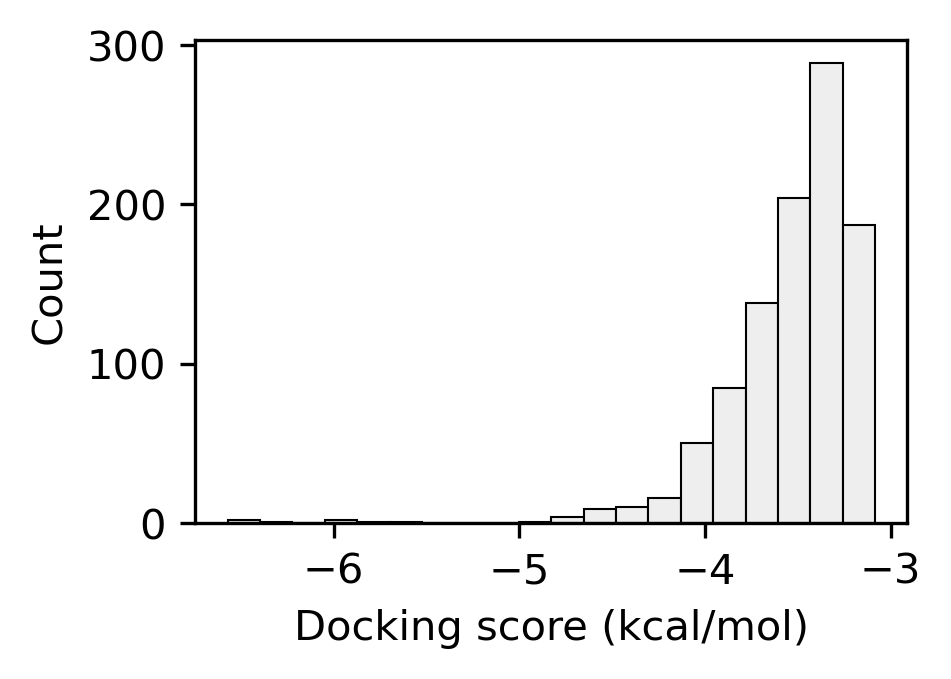

In [24]:
fig = plt.figure(figsize=(83/25.4, 60/25.4))

plt.hist(vina_score, bins=20, color="#EEEEEE", edgecolor="black", linewidth=0.5)
plt.xlabel("Docking score (kcal/mol)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("Docking_score.pdf", dpi=300)
plt.show()

# LoCoMock scoring

In [25]:
def calc_WH_score():
    #Kucerka et al., 2008 Biophys. J. 95: 2356-2367
    #https://dx.doi.org/10.1529%2Fbiophysj.108.132662
    mol_logp = sum([x[0] for x in contribs])
    WH_scores = []
    for pdb_file in sorted(glob.glob(f'./result_pdb/ligand_*.pdb'), key = lambda x: int(x.replace(f"./result_pdb/ligand_","").replace(".pdb",""))):
        try:
            pose = Chem.MolFromPDBFile(pdb_file)
            coordinates = [a for a in pose.GetConformers()[0].GetPositions()]
        except:
            print(pdb_file)
            WH_scores.append(100)
            continue
        WH_score = []
        for coor, cont in zip(coordinates, contribs):
            if coor[2] <0 :
                sigmoid = -(1/ (1 + math.e**-( coor[2]+membrane_pos)))
                WH_score.append(sigmoid *cont[0])
            elif coor[2] >= 0 :
                sigmoid = -(1/ (1 + math.e**( coor[2]-membrane_pos)))
                WH_score.append(sigmoid *cont[0])
        WH_scores.append(sum(WH_score))

    np.savetxt(f"WH_score.txt", WH_scores)
    
    return WH_scores

## WH score

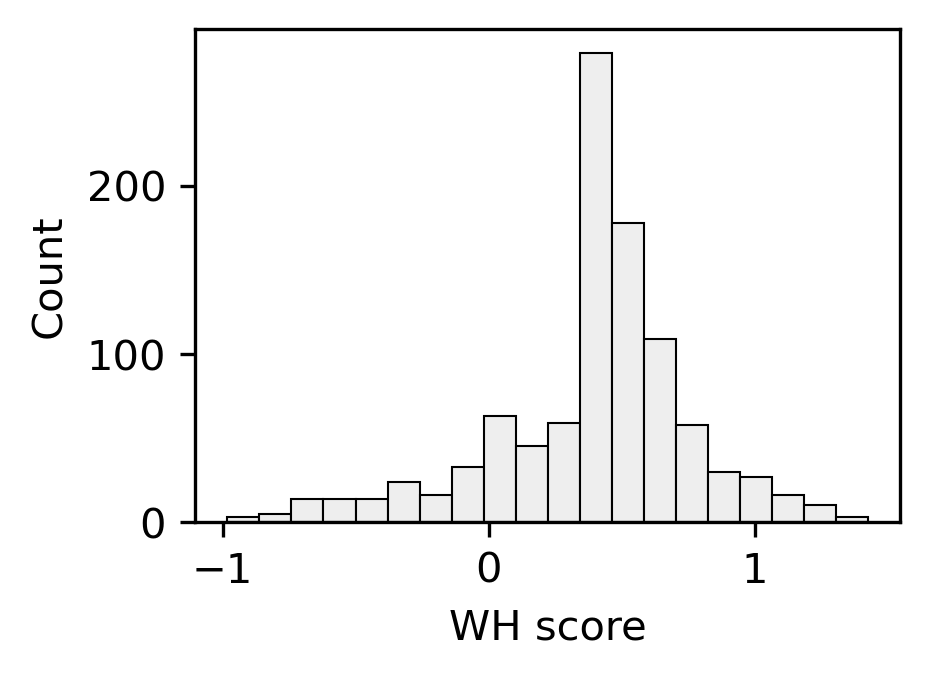

In [26]:
WH_score = calc_WH_score()
fig = plt.figure(figsize=(83/25.4, 60/25.4))
plt.hist(WH_score, bins=20, color="#EEEEEE", edgecolor="black", linewidth=0.5)
plt.xlabel("WH score")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("WH_score.pdf", dpi=300)
plt.show()

np.savetxt("WH_score.txt", WH_score)

## LoCoMock score

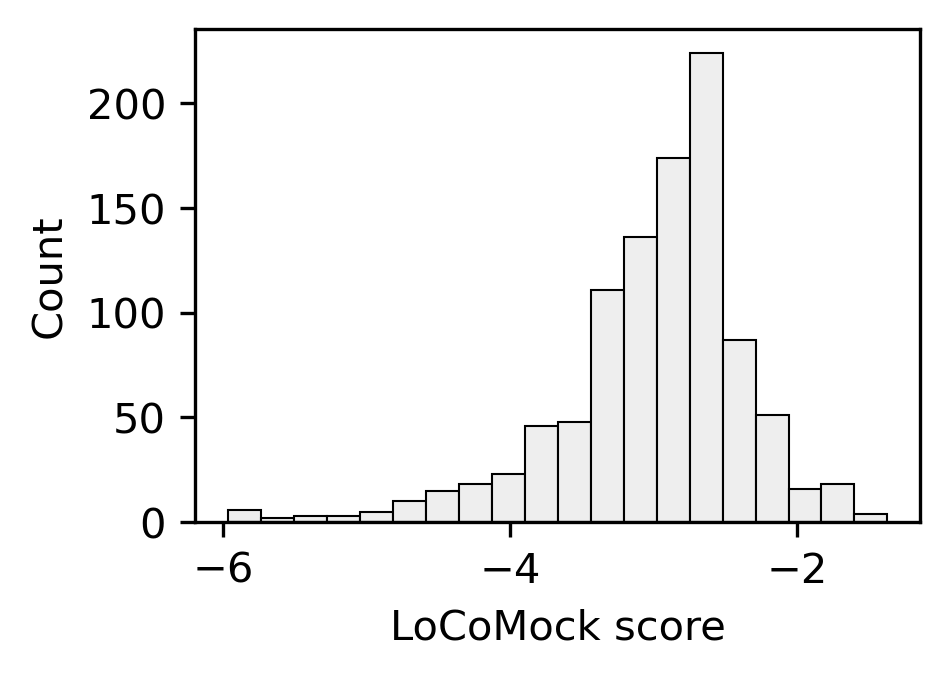

In [27]:
multiple_score = [v+(2.303*(8.314*300)*(logp)/4.184/1000)  for v, logp in zip(vina_score, WH_score)]
fig = plt.figure(figsize=(83/25.4, 60/25.4))
plt.hist(multiple_score, bins=20, color="#EEEEEE", edgecolor="black", linewidth=0.5)
plt.xlabel("LoCoMock score")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("LoCoMock_score.pdf", dpi=300)

plt.show()

np.savetxt("locomock_score.txt", multiple_score)

## save results

In [28]:
WH_scores = np.loadtxt("WH_score.txt")

In [29]:
vina_score = np.loadtxt("vina_energy.txt")

In [30]:
multiple_score = np.loadtxt("locomock_score.txt")

# Best poses by LoCoMock

In [31]:
num_best = 10

In [32]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('protein_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

for i in sorted(enumerate(multiple_score), key=lambda x: x[1], reverse=False)[:num_best]:
    view.addModel(open(f"./result_pdb/ligand_{i[0]}.pdb",'r').read(),format='mol2')
    ref_m = view.getModel()
    ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Best poses by Vina

In [33]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('protein_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

for i in sorted(enumerate(vina_score), key=lambda x: x[1])[:num_best]:
    view.addModel(open(f"./result_pdb/ligand_{i[0]}.pdb",'r').read(),format='mol2')
    ref_m = view.getModel()
    ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Export models

In [34]:
file_list = ""
for i, s in enumerate(multiple_score):
    file_list += f" ./result_pdb/ligand_{i}.pdb"
!cat $file_list | sed -e "s/END/ENDMDL/g" > ./ligand_all.pdb

file_list = ""
for i in sorted(enumerate(multiple_score), key=lambda x: x[1], reverse=False)[:10]:
    file_list += f" ./result_pdb/ligand_{i[0]}.pdb"
!cat $file_list | sed -e "s/END/ENDMDL/g" > ./ligand_best.pdb

file_list = ""
for i in sorted(enumerate(multiple_score), key=lambda x: x[1], reverse=False)[-10:]:
    file_list += f" ./result_pdb/ligand_{i[0]}.pdb"
!cat $file_list | sed -e "s/END/ENDMDL/g" > ./ligand_worst.pdb

In [35]:
file_list = ""
for i in sorted(enumerate(multiple_score), key=lambda x: x[1], reverse=False)[:num_best]:
    file_list += f" ./result_pdb/ligand_{i[0]}.pdb"
!cat $file_list | sed -e "s/END/ENDMDL/g" > ./ligand_best_LoCoMock.pdb

file_list = ""
best_100_list = []
for i in sorted(enumerate(vina_score), key=lambda x: x[1], reverse=False)[:num_best]:
    file_list += f" ./result_pdb/ligand_{i[0]}.pdb"
!cat $file_list | sed -e "s/END/ENDMDL/g" > ./ligand_best_vina.pdb